<a href="https://colab.research.google.com/github/mohammadbadi/CrimeAnalytics_Clustering/blob/main/Code%20Sections/5.5%20KMeans%20Feature%20Importance%20%26%205.6%20K-Elbow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **5.5 KMeans Feature Importance & 5.6 K-Elbow - Approach 1**

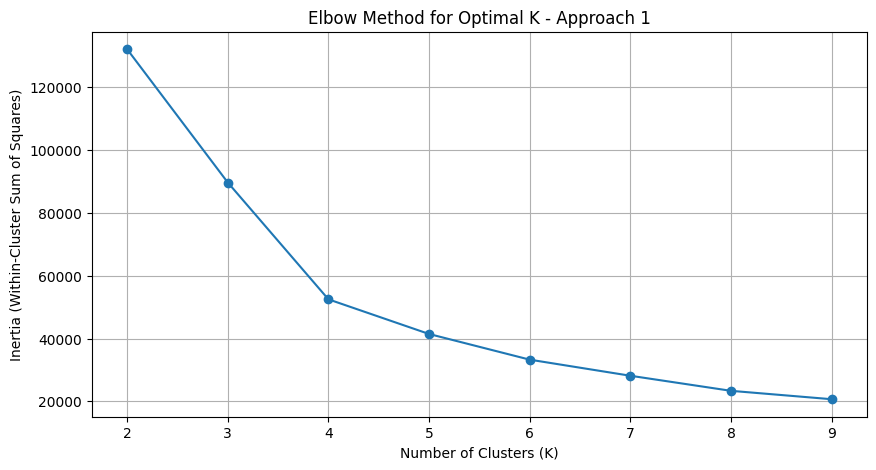

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

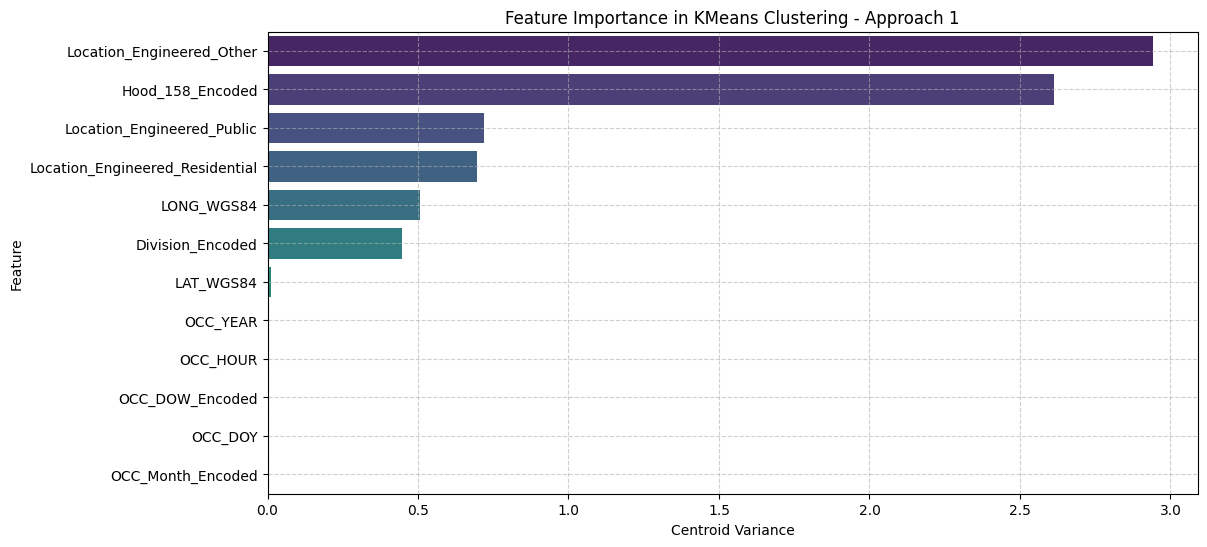

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

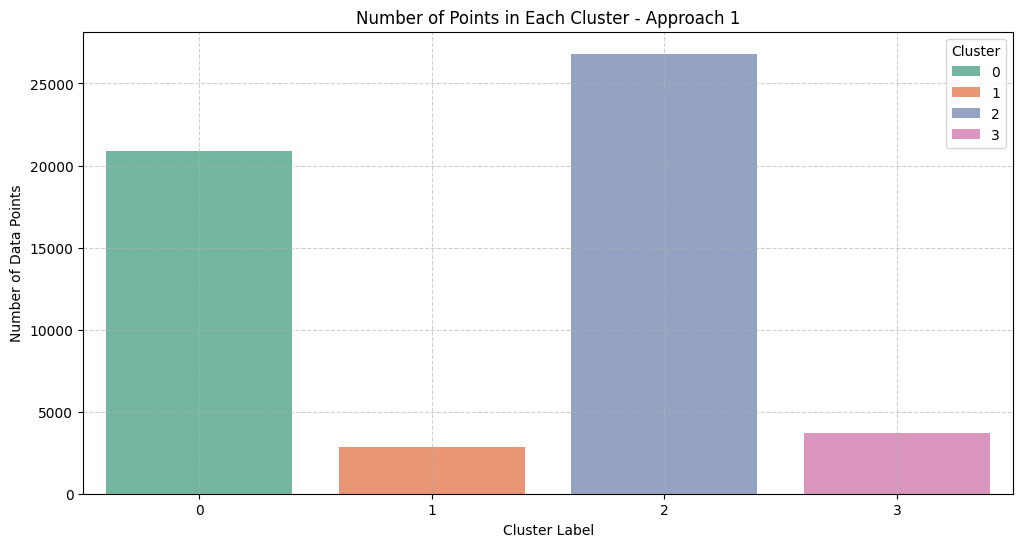

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [2]:
import warnings                                                                   # Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from IPython.display import display, HTML
from google.colab import files

print("\n\n")
warnings.filterwarnings("ignore", category=DeprecationWarning)                    # Ignore Deprecation Warnings
warnings.filterwarnings("ignore", category=FutureWarning)                         # Ignore Future Warnings

url = "https://raw.githubusercontent.com/mohammadbadi/CrimeAnalytics_Clustering/refs/heads/main/Output_CSV/FE_Encoded.csv"  # Read the dataset from CSV file
df = pd.read_csv(url)

continuous_features = ['OCC_YEAR', 'OCC_DOY', 'OCC_HOUR', 'LONG_WGS84', 'LAT_WGS84']  # Define Continuous Features
encoded_features = ['OCC_Month_Encoded', 'OCC_DOW_Encoded', 'Hood_158_Encoded',   # Define Encoded Features
                    'Division_Encoded', 'Location_Engineered_Other',
                    'Location_Engineered_Public', 'Location_Engineered_Residential']
features = continuous_features + encoded_features
                                                                                  # Build preprocessor and pipeline for KMeans Clustering
scaler = StandardScaler()                                                         # Standardization
preprocessor = ColumnTransformer([('num', scaler, features)])
pipeline = Pipeline([                                                             # KMeans Clustering Pipeline (n_clusters=4 based on K-Elbow)
    ('preprocessor', preprocessor),
    ('kmeans', KMeans(n_clusters=4, random_state=42, n_init=10))
])
pipeline.fit(df)                                                                  # Fit the Pipeline
df_processed = pipeline.transform(df)                                             # Transform the Data

kmeans = pipeline.named_steps['kmeans']                                           # Extract KMeans Model, assign cluster labels, compute centroid variance
df['Cluster'] = kmeans.labels_
centroids = kmeans.cluster_centers_
centroid_variance = np.var(centroids, axis=0)
importance_df = pd.DataFrame({'Feature': features, 'Centroid Variance': centroid_variance})\
                  .sort_values(by='Centroid Variance', ascending=False)

sil_score = silhouette_score(df_processed, kmeans.labels_)                        # Compute Silhouette Score, Davies-Bouldin Index, Calinski-Harabasz Index, and Inertia
db_index = davies_bouldin_score(df_processed, kmeans.labels_)
ch_index = calinski_harabasz_score(df_processed, kmeans.labels_)
inertia_value = kmeans.inertia_
                                                                                  # Plot: K-Elbow Method
inertia_values = []                                                               # Compute inertia for K values from 2 to 9
K_range = range(2, 10)
for k in K_range:
    kmeans_test = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_test.fit(df_processed)
    inertia_values.append(kmeans_test.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(K_range, inertia_values, marker='o', linestyle='-')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia (Within-Cluster Sum of Squares)")
plt.title("Elbow Method for Optimal K - Approach 1")
plt.grid(True)
plt.savefig("5.5 K-Elbow.png", dpi=300, bbox_inches='tight')                      # Save Elbow plot
plt.show()
files.download("5.5 K-Elbow.png")                                                 # Download the Elbow plot
display(HTML("<br><br>"))
                                                                                  # Text Output: Inertia Values
inertia_html = """
<p style="color: darkblue; font-size: 18px; font-weight: bold;">
    Inertia values for different K:
"""
for k, inertia in zip(K_range, inertia_values):
    inertia_html += f"<br>For K = <span style='color: blue;'>{k}</span>: <span style='color: blue;'>{inertia:.2f}</span>"
inertia_html += "</p>"
display(HTML(inertia_html))
display(HTML("<br><br>"))
                                                                                  #  Plot: K-Means Feature Importance
plt.figure(figsize=(12, 6))
sns.barplot(data=importance_df, x='Centroid Variance', y='Feature', palette='viridis')
plt.xlabel("Centroid Variance")
plt.ylabel("Feature")
plt.title("Feature Importance in KMeans Clustering - Approach 1")
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig("5.6 K-Means Feature Importance.png", dpi=300, bbox_inches='tight')   # Save Feature Importance plot
plt.show()
files.download("5.6 K-Means Feature Importance.png")                              # Download Feature Importance plot
display(HTML("<br><br>"))
                                                                                  # Plot: Number of Points in Each Cluster
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Cluster', hue='Cluster', palette="Set2", dodge=False)
plt.title("Number of Points in Each Cluster - Approach 1")
plt.xlabel("Cluster Label")
plt.ylabel("Number of Data Points")
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig("5.6 K-Means Cluster Distribution.png", dpi=300, bbox_inches='tight') # Save Cluster Distribution plot
plt.show()
files.download("5.6 K-Means Cluster Distribution.png")                            # Download Cluster Distribution plot
display(HTML("<br><br>"))
                                                                                  # Text Output: Cluster Distribution
cluster_counts = df['Cluster'].value_counts().sort_index()
cluster_html = """
<p style="color: darkblue; font-size: 18px; font-weight: bold;">
    Number of data points in each cluster:
"""
for cluster, count in cluster_counts.items():
    cluster_html += f"<br><span style='color: blue;'>Cluster {cluster}</span>: <span style='color: green;'>{count}</span> data points"
cluster_html += "</p>"
display(HTML(cluster_html))
display(HTML("<br><br>"))
                                                                                  # Build HTML Table for K-Means Clustering Analysis
html_table = f"""
<table style='border-collapse: collapse; font-size: 18px; width: 100%; max-width: 900px; table-layout: fixed;'>
    <thead>
        <tr style='background-color: #2f4f4f; color: white;'>
            <th colspan="3" style="text-align: center; font-size: 24px; padding: 8px;">
                KMEANS Clustering Analysis - Approach 1
            </th>
        </tr>
        <tr>
            <td colspan="3" style="border: 1px solid #dddddd; padding: 8px; text-align: center; white-space: normal; word-wrap: break-word;">
                Based on the Optimal K value from the K-Elbow method, KMeans was performed with 4 clusters (n=4), which produced the following clustering statistics:
                <strong>Silhouette Score:</strong> {sil_score:.2f},
                <strong>Davies-Bouldin Index:</strong> {db_index:.2f},
                <strong>Calinski-Harabasz Index:</strong> {ch_index:.2f}, and
                <strong>Inertia:</strong> {inertia_value:.2f}.
                Centroid Variance represents the variance of the cluster centroids for each feature, reflecting its contribution to the clustering structure.
            </td>
        </tr>
        <tr style='background-color: #4CAF50; color: white;'>
            <th style='border: 1px solid #dddddd; padding: 8px;'>S/N</th>
            <th style='border: 1px solid #dddddd; padding: 8px;'>Feature</th>
            <th style='border: 1px solid #dddddd; padding: 8px;'>Centroid Variance</th>
        </tr>
    </thead>
    <tbody>
"""
for idx, row in enumerate(importance_df.itertuples(), start=1):                   # Add a row for each feature's centroid variance
    feature_val = row.Feature
    variance_val = f"{row[2]:.4f}"                                                # row[2] is the 'Centroid Variance'
    html_table += f"""
        <tr style='border: 1px solid #dddddd;'>
            <td style='border: 1px solid #dddddd; padding: 8px; text-align: center;'>{idx}</td>
            <td style='border: 1px solid #dddddd; padding: 8px;'>{feature_val}</td>
            <td style='border: 1px solid #dddddd; padding: 8px; text-align: right;'>{variance_val}</td>
        </tr>
    """
html_table += """
    </tbody>
</table>
"""

display(HTML(html_table))                                                         # Display the HTML table
display(HTML("<br><br>"))
                                                                                  # Save the HTML table as file "5.6 K-Means Feature Importance.html" and download it
html_table_path = "5.6 K-Means Feature Importance.html"
with open(html_table_path, "w", encoding="utf-8") as f:
    f.write(html_table)
files.download(html_table_path)                                                   # Download the HTML table file
df.to_csv("FE_Encoded_with_Clusters.csv", index=False)                            # Save the updated dataset with cluster labels
files.download("FE_Encoded_with_Clusters.csv")                                    # Download the updated dataset with cluster labels
                                                                                  # Rationale Explanation for Choosing n=4
if len(inertia_values) >= 5:
    inertia_reduction_k3_k4 = ((inertia_values[1] - inertia_values[2]) / inertia_values[1]) * 100
    inertia_reduction_k4_k5 = ((inertia_values[2] - inertia_values[3]) / inertia_values[2]) * 100
else:
    inertia_reduction_k3_k4 = inertia_reduction_k4_k5 = 0

explanation = f"""
<p style="color: black; font-size: 18px; font-weight: bold;">
    The K-Elbow method shows that the inertia value decreases notably as K increases from <span style="color: blue;">2</span> to <span style="color: blue;">4</span>. For example, when K increases from <span style="color: blue;">2</span> to <span style="color: blue;">3</span>, inertia decreases from <span style="color: blue;">{inertia_values[0]:.2f}</span> to <span style="color: blue;">{inertia_values[1]:.2f}</span>, and from K = <span style="color: blue;">3</span> to K = <span style="color: blue;">4</span> it decreases to <span style="color: blue;">{inertia_values[2]:.2f}</span> (a reduction of <span style="color: blue;">{inertia_reduction_k3_k4:.1f}%</span>). Beyond K = <span style="color: blue;">4</span>, the reduction in inertia becomes less dramatic (e.g. a further reduction of <span style="color: blue;">{inertia_reduction_k4_k5:.1f}%</span> from K = <span style="color: blue;">4</span> to K = <span style="color: blue;">5</span>).
</p>
<p style="color: black; font-size: 18px; font-weight: bold;">
    The cluster distribution is also reasonable:
    <br><span style="color: blue;">Cluster 0</span>: <span style="color: green;">{cluster_counts.get(0, 0)}</span> data points
    <br><span style="color: blue;">Cluster 1</span>: <span style="color: green;">{cluster_counts.get(1, 0)}</span> data points
    <br><span style="color: blue;">Cluster 2</span>: <span style="color: green;">{cluster_counts.get(2, 0)}</span> data points
    <br><span style="color: blue;">Cluster 3</span>: <span style="color: green;">{cluster_counts.get(3, 0)}</span> data points
</p>
<p style="color: black; font-size: 18px; font-weight: bold;">
    Based on the significant drop in inertia up to K = <span style="color: blue;">4</span> and a balanced cluster distribution, using <span style="color: blue;">4</span> clusters (n=4) for KMeans clustering is a good choice.
</p>
"""
display(HTML(explanation))